# Libraries

In [4]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

## Data Prep

In [5]:
df_purchase = pd.read_csv(
    "/home/angelo/repos/vscode_repos/customer_analytics_2022/Data/purchase data.csv"
)

In [6]:
scaler = pickle.load(
    open(
        "/home/angelo/repos/vscode_repos/customer_analytics_2022/pickle_data_models/scaler.pickle",
        "rb",
    )
)

pca = pickle.load(
    open(
        "/home/angelo/repos/vscode_repos/customer_analytics_2022/pickle_data_models/pca_3.pickle",
        "rb",
    )
)

kmeans_pca = pickle.load(
    open(
        "/home/angelo/repos/vscode_repos/customer_analytics_2022/pickle_data_models/kmeans_pca_4.pickle",
        "rb",
    )
)

#### Apply imported models 



In [7]:
# only apply transform; fit would mean that the model is retrained; here we only want to apply it on the data --> so only transform
features = df_purchase.iloc[:, -7:]

# apply the scaler
df_purchase_segm_std = scaler.transform(features)

In [8]:
#### apply the already trained scaler on the new data 
# remember that customers may be duplicates
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

In [9]:
#### apply the already trained pca_3 (here just pca) on the data 
# now apply the kmeans on it: use the predict method here
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

In [10]:
#### apply the already trained kmeans model which was trained on the 3 components of the pca model and had k = 4 groups
df_purchase_predictors = df_purchase.copy()
df_purchase_predictors["Segment"] = purchase_segm_kmeans_pca

In [11]:
#### this is now the new dataframe containing the predicted segments for the customers
df_purchase_predictors = df_purchase.copy()
df_purchase_predictors["Segment"] = purchase_segm_kmeans_pca

In [12]:
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, 
                                prefix = 'Segment',
                                prefix_sep = '_')

In [13]:
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

In [14]:
df_pa = df_purchase_predictors.copy()

In [15]:
df_pa.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,2,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,47,1,110866,1,0,2,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0


## Purchase Probability Model

The model task:
dependent: Incidence varaible

independent: Price

We want to know whether a purchase has happened based on the purchase price of a product assuming that purchase probabaility is influenced by price.

In [16]:
Y = df_pa['Incidence']


create price variable irrespective of the brand;

possible choices to consider here:
- i) min and max price which are good indicators how expensive a new product is
- ii) mean or median price


NOTE: the choice here is mean of all prices (while in a store, the customer has the choice to grab 5 different brands... we just average these 5 prices together into one per purchase opportunity in the dataset 8per instance) to see how much of the variance in Incidence can be explained by the average price of all brands together )

We take mean price here as we are only looking for the pruchase probability -- meaning we are lloking for the probability that the customer buys from a CATEGORY and not specific item; so the average price of the category is a good way

In [17]:
# create price variable irrespective of the brand
## mean price is chosen for all prices (Price_1 to Price_5) per row
X = pd.DataFrame()

X['Mean_Price'] = (df_pa['Price_1'] +
                    df_pa['Price_2'] +
                    df_pa['Price_3'] +
                    df_pa['Price_4'] +
                    df_pa['Price_5'] ) / 5



a solver in a models such as LogisticRegression is the technique for the iteration-optimization problem in logisitc regression such as 'sag'

In [18]:
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

by fitting a logistic regression on this data, this command estimates the purchase probabaiility and stores the results in the model_purchase instance of the trained LogisticRegression model.



In [19]:
# coef_ holds the coefficients for a model; here univariate price
model_purchase.coef_

array([[-2.34544607]])

Analysis: negative coefficient indicates that an increase in price will decrease the probabaility of purchase and vice versa

However, logistic regression can do more: this model also quantifies the exact  relationship between pruice and probability of purchase in addition to magnitude (elasiticity)

## Price Elasticity of Purchase Probability

Price elasitiy of purchase probabauility is the percentage change in prucahse probability in response to a one percent change in price in the product category


the coefficient for price here array([[-2.34904564]]) is the change in probabaility given the price; this is what the coefficient shows:

As such we want to see different values for mean price and see how the probabaility 

In [20]:
# create a price range to test
df_pa.loc[:, ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


minprice is 1.1€; and maxprice is 2.8€

--> expand this range a little got get a better understanding of the elasiticity such as [0.5; 3.5] or even [0 ; 5]

In [21]:
# add a 0.01 price change 
price_range = np.arange(0.5, 3.5, 0.01)

In [22]:
df_price_range = pd.DataFrame(price_range)

In [23]:
# now predict the purchase probabability using the trained model
Y_pr = model_purchase.predict_proba(df_price_range)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [24]:
Y_pr

array([[0.08200778, 0.91799222],
       [0.08379089, 0.91620911],
       [0.08560916, 0.91439084],
       [0.08746311, 0.91253689],
       [0.08935329, 0.91064671],
       [0.09128023, 0.90871977],
       [0.09324448, 0.90675552],
       [0.09524656, 0.90475344],
       [0.09728702, 0.90271298],
       [0.09936639, 0.90063361],
       [0.1014852 , 0.8985148 ],
       [0.103644  , 0.896356  ],
       [0.10584331, 0.89415669],
       [0.10808366, 0.89191634],
       [0.11036558, 0.88963442],
       [0.11268959, 0.88731041],
       [0.1150562 , 0.8849438 ],
       [0.11746594, 0.88253406],
       [0.11991931, 0.88008069],
       [0.12241681, 0.87758319],
       [0.12495894, 0.87504106],
       [0.12754619, 0.87245381],
       [0.13017904, 0.86982096],
       [0.13285796, 0.86714204],
       [0.13558342, 0.86441658],
       [0.13835586, 0.86164414],
       [0.14117574, 0.85882426],
       [0.14404348, 0.85595652],
       [0.14695951, 0.85304049],
       [0.14992423, 0.85007577],
       [0.

the predicted output above for the different prices shows the class probabilities for 0 & 1 (so unsucessful and successfull); each row == 100%

Probabbility of pruchase (== 1) is the second column

In [25]:
# get only the second column
purchase_pr = Y_pr[:][:, 1]

Question now is:

How is demand for the product change for a given change in price? --> elasiticies will answer this


Definition of price elasiticiy 

E = (delta_Pr(purchase) / (Pr(purchase)) / (delta_Price/Price))

(=) E = beta * price * (1 - Pr(purchase))

In [26]:
# price elastiticity == price coeff of the model
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

#### The above array contains the price elasticity at each price point

In [27]:
df_price_elasticities = pd.DataFrame(price_range)

In [28]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: 'Price_Point'})

In [29]:
df_price_elasticities['Mean_PE'] = pe

each row we have the price point and the price elastitiy of that price point (so a one percent change in price at price point x will increase/decrease the purchase probabaility by xxx%)

Mean_PE is already in percent; eg the first instqance at price point 0.5 --> a price increase of 1% results in a purchase probability decrease of 0.096% 

In [30]:
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096172
1,0.51,-0.100229
2,0.52,-0.104412
3,0.53,-0.108724
4,0.54,-0.113170
...,...,...
295,3.45,-8.003209
296,3.46,-8.028444
297,3.47,-8.053644
298,3.48,-8.078811


In [31]:
pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096172
1,0.51,-0.100229
2,0.52,-0.104412
3,0.53,-0.108724
4,0.54,-0.113170
5,0.55,-0.117751
6,0.56,-0.122472
7,0.57,-0.127336
8,0.58,-0.132345
9,0.59,-0.137505


## Analyse the elastitiy result

Text(0.5, 1.0, 'Price Elastiticy of Purchase Probabaility')

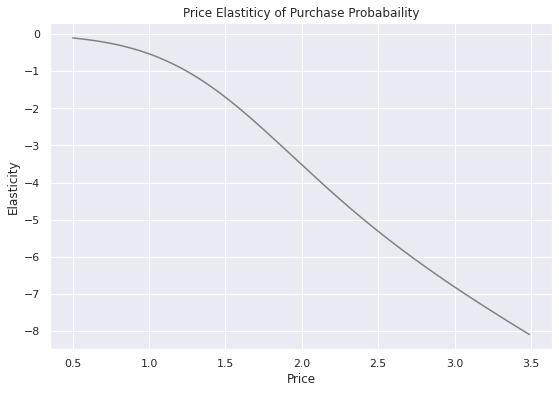

In [32]:
plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elastiticy of Purchase Probabaility')

More towards the right, the leass likely it is for people to buy from a category; 

However, this plot of price elasitiyty is very interresting with regards to the rate of decrease --> the decrease in puchase probabauility is leveling off around the 1.1 mark and turning quite steep

Additionally, all price elastiticies are negative: the reason is simple: an increased price will decrease the lieklyhood of buying the product (and coef_ is negative: inverse proportionality of price and purcahse probabuility)

Remember: Price elastiticy measures the percentage change in an outcome (here Purchase probability); example: at price 1.1€ the E = -0.6919 (this is already in percent)--> So for a 1% price increase, the probability of puirchase decreases by 0.69%


|E| < 1 % --> inelastic (y-axis)

|E| >= 1 % --> elastic (y-axis)

is it inelastic or elastic? 
- A change in price by 1% at price point 0.5 leads to LESS then 1% decrease in purchase probabaiulity --> so it is inelastic (all below 1%!!!)
- A price change at 1.5 is MORE than 1% decrease in purchase probabaiulity --> so here it is elastic


recommendation: for inelastic values we should increase the Price ; BUT FOR elastic prices we should decrease our prices!


To do: find those prices that are inelastic and those that are elastic; so find where price elastiticiy turns from elastic to inelastic ---> this is at price point 1.25 ; so at product prices lower that 1.25 we can increase the product price; For prices higher than 1.25 we have more to gain from lower prices



## Now proceed to purchase probabaility of category but now of the different segments!

## Proceed to brand Purchase probabaility for 